In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [2]:
# set working directory
os.chdir('D:/Dataset/bank_additional')

# 1) The Data

In [3]:
# load dataset
df = pd.read_csv('train.csv')
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon ...         1    999         0  nonexistent          1.1   
1   may         mon ...         1    999         0  nonexistent          1.1   
2   may         mon ...         1    999         0  nonexistent          1.1   
3   may         mon ...         1    999         0  nonexistent          1.1   
4   may         mon ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

# 1.1) Data Overview

In [4]:
print('No of Rows      :', df.shape[0])
print('No of Attributes:', df.shape[1])
print('\nAttributes Name:\n', df.columns)
print('\nNo of Missing Values:\n', df.isnull().sum().sort_values(ascending=False))
print('\nUnique Values:\n', df.nunique().sort_values(ascending = False))

No of Rows      : 41188
No of Attributes: 21

Attributes Name:
 Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

No of Missing Values:
 y                 0
day_of_week       0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
duration          0
nr.employed       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
age               0
dtype: int64

Unique Values:
 duration          1544
euribor3m          316
age                 78
campaign            42
pdays               27
cons.conf.idx       26
cons.price.idx      26
job   

# 2) Data Manipulation

In [5]:
# numbere of contact performed during this campaign
df['campaign'] = np.where(df['campaign'] > 6, 7, df['campaign'])

# define function for 'pdays' to make group for days passed after client was last contacted from previous campaign
def days_group(df):
    if df['pdays'] <= 10:
        return 'day_pass_0-10'
    elif (df['pdays'] > 10) & (df['pdays'] <= 20):
        return 'day_pass_10-20'
    elif (df['pdays'] > 20) & (df['pdays'] <= 27):
        return 'day_pass_20-27'
    elif df['pdays'] > 27:
        return 'not_contacted'
    
df['days_group']  = df.apply(lambda df: days_group(df), axis = 1)
df = df.drop('pdays', axis = 1)

# drop 'duration' attribute because i want realistic prediction
df = df.drop('duration', axis = 1)

# define function for 'age' attribute
def age_group(df):
    if df['age'] <= 20:
        return 'age_0-20'
    elif (df['age'] > 20) & (df['age'] <= 40):
        return 'age_20-40'
    elif (df['age'] > 40) & (df['age'] <= 60):
        return 'age_40-60'
    elif df['age'] > 60:
        return 'age_gt_60'
    
df['age_group'] = df.apply(lambda df: age_group(df), axis = 1)
df = df.drop('age', axis = 1)

df = df.rename(columns = {'y':'output'})


# target columns
target_col = ['output']

# categorical variables
cat_cols = ['job','marital','education','default','housing','loan','contact',
           'month','day_of_week','poutcome','days_group','age_group']

# numerical vaiables
num_cols = [x for x in df.columns if x not in target_col + cat_cols]

sub = df[df['output'] == 'yes']
not_sub = df[df['output'] == 'no']

# 3) Exploratory Data Analysis

# 3.1) Customer Subscription in Data

In [6]:
# label
lab = df['output'].value_counts().tolist()

# val
val = df['output'].value_counts().values.tolist()

trace = go.Pie(labels = lab,
              values = val,
              marker = dict(colors = ['royalblue', 'lime'],
                           line = dict(color = 'white',
                                      width = 1.3)
                           ),
              rotation = 90,
              hoverinfo = 'label+value+text',
              hole = .5
              )

layout = go.Layout(dict(title = 'Customer Subcription in Data',
                          plot_bgcolor = 'rgb(243,243,243)',
                          paper_bgcolor = 'rgb(243,243,243)'
                          )
                  )

data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

# 3.2) Variable Distribution in Data

In [7]:
# function for pie plot for customer attrition type
def plot_pie(column):
    trace1 = go.Pie(values = sub[column].value_counts().values.tolist(),
                   labels = sub[column].value_counts().keys().tolist(),
                   marker = dict(line = dict(width = 2,
                                            color = 'rgb(243,243,243)',
                                            )
                                ),
                   hoverinfo = 'label+percent+name',
                   domain = dict(x = [0, .48]),
                   name = 'Customer Subscribe',
                   hole = .5
                   )
    
    trace2 = go.Pie(values = not_sub[column].value_counts().values.tolist(),
                   labels = not_sub[column].value_counts().keys().tolist(),
                   marker = dict(line = dict(width = 2,
                                            color = 'rgb(243,243,243)',
                                            )
                                ),
                   hoverinfo = 'label+percent+name',
                   domain = dict(x = [.52, 1]),
                   name = 'Customer Not Subscribe',
                   hole = .5
                   )
    
    layout = go.Layout(dict(title = column + 'Distribution in Customer Subscription',
                           plot_bgcolor = 'rgb(243,243,243)',
                           paper_bgcolor = 'rgb(243,243,243)',
                           annotations = [dict(text = 'Customer Subscribe',
                                              font = dict(size = 13),
                                              showarrow = False,
                                              x = .15, y = .5),
                                         dict(text = 'Customer Not Subscribe',
                                             font = dict(size = 13),
                                             showarrow = False,
                                             x = .88, y = .5
                                             )
                                         ]
                           )
                      )
    
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)

In [8]:
# for all categorical columns plot pie
for i in cat_cols:
    plot_pie(i)

In [9]:
# function for histogram for customer subscription
def histogram(column):
    trace1 = go.Histogram(x = sub[column],
                         histnorm = 'percent',
                         name = 'Customer Subscribe',
                         marker = dict(line = dict(width = .5,
                                                  color = 'black'
                                                  )
                                      ),
                         opacity = .9
                         )
    trace2 = go.Histogram(x = not_sub[column],
                         histnorm = 'percent',
                         name = 'Customer Not Subscribe',
                         marker = dict(line = dict(width = .5,
                                                  color = 'black'
                                                  )
                                      ),
                         opacity = .9
                         )
    layout = go.Layout(dict(title = column + 'Distribution in Customer Subscription',
                           plot_bgcolor = 'rgb(243,243,243)',
                           paper_bgcolor = 'rgb(243,243,243)',
                           xaxis = dict(gridcolor = 'rgb(255,255,255)',
                                       title = column,
                                       zerolinewidth = 1,
                                       ticklen = 5,
                                       gridwidth = 2
                                       ),
                           yaxis = dict(gridcolor = 'rgb(255,255,255)',
                                       title = 'percent',
                                       zerolinewidth = 1,
                                       ticklen = 5,
                                       gridwidth = 2
                                       )
                           )
                      )
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)

In [10]:
# for all numerical columns plot histogram
for i in num_cols:
    histogram(i)

In [11]:
# function for scatter plot matrix for numerical columns in data
def scatter_matrix(data):
    data = data.sort_values(by = 'output', ascending = True)
    classes = data['output'].unique().tolist()
    classes
    
    classes_code = {classes[k]: k for k in range(2)}
    classes_code
    
    color_vals = [classes_code[cl] for cl in data['output']]
    color_vals
    
    pl_colorscale = 'Portland'
    
    pl_colorscale
    
    text = [data.loc[k, 'output'] for k in range(len(data))]
    text
    
    trace = go.Splom(dimensions = [dict(label = 'campaign',
                                      values = data['campaign']),
                                  dict(label = 'previous',
                                      values = data['previous']),
                                  dict(label = 'emp.var.rate',
                                      values = data['emp.var.rate']),
                                  dict(label = 'cons.price.idx',
                                      values = data['cons.price.idx']),
                                  dict(label = 'cons.conf.idx',
                                      values = data['cons.conf.idx']),
                                  dict(label = 'euribor3m',
                                      values = data['euribor3m']),
                                  dict(label = 'nr.employed',
                                      values = data['nr.employed'])],
                    text = text,
                    marker = dict(color = color_vals,
                                 colorscale = pl_colorscale,
                                 size = 3,
                                 showscale = False,
                                 line = dict(width = .1,
                                            color = 'rgb(230,230,230)'
                                            )
                                 )
                    )
    
    axis = dict(showline = True,
               zeroline = False,
               gridcolor = '#fff',
               ticklen = 4
               )
    
    layout = go.Layout(dict(title = 
                           'Scatter plot matrix for Numerical columns for customer attrition',
                           autosize = False,
                           height = 2500,
                           width = 2500,
                           dragmode = 'select',
                           hovermode = 'closest',
                           plot_bgcolor = 'rgba(240,240,240, 0.95)',
                           xaxis1 = dict(axis),
                           yaxis1 = dict(axis),
                           xaxis2 = dict(axis),
                           yaxis2 = dict(axis),
                           xaxis3 = dict(axis),
                           yaxis3 = dict(axis),
                           xaxis4 = dict(axis),
                           yaxis4 = dict(axis),
                           xaxis5 = dict(axis),
                           yaxis5 = dict(axis),
                           xaxis6 = dict(axis),
                           yaxis6 = dict(axis),
                           xaxis7 = dict(axis),
                           yaxis7 = dict(axis),
                           )
                      )
    
    data = [trace]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)

In [12]:
# scatter_matrix(df)

# 3.3) Customer Subscription in Age Group

In [13]:
ag_su = sub['age_group'].value_counts().reset_index()
ag_su.columns = ['age_group', 'count']
ag_nsu = not_sub['age_group'].value_counts().reset_index()
ag_nsu.columns = ['age_group','count']

trace1 = go.Bar(x = ag_su['age_group'], y = ag_su['count'],
               name = 'Customer Subscribe',
               marker = dict(line = dict(width = .5, color = 'black')),
               opacity = .9)

trace2 = go.Bar(x = ag_nsu['age_group'], y = ag_nsu['count'],
               name = 'Customer not Subscribe',
               marker = dict(line = dict(width = .5, color = 'black')),
               opacity = .9)

layout = go.Layout(dict(title = 'Customer Subscription in Age Group',
                       plot_bgcolor = 'rgb(243,243,243)',
                       paper_bgcolor = 'rgb(243,243,243)',
                       xaxis = dict(gridcolor = 'rgb(255,255,255)',
                                   title = 'Age Group',
                                   zerolinewidth = 1, ticklen = 5, gridwidth = 2),
                       yaxis = dict(gridcolor = 'rgb(255,255,255)',
                                   title = 'count',
                                   zerolinewidth = 1, ticklen = 5, gridwidth = 2),
                       )
                  )

data = [trace1, trace2]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

# 4) Data Preprocessing

In [14]:
df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'output', 'days_group', 'age_group'],
      dtype='object')

In [15]:
# target columns
target_col = ['output']

# categorical variables
cat_cols = ['job','marital','education','default','housing','loan','contact',
           'month','day_of_week','poutcome','days_group','age_group']

# numerical vaiables
num_cols = [x for x in df.columns if x not in target_col + cat_cols]

# binary column with 2 values
bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()

# column more than 2 values
multi_cols = [x for x in cat_cols if x not in bin_cols]

In [16]:
# label encoding binary column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in bin_cols:
    df[i] = le.fit_transform(df[i])

In [17]:
# duplicating columns for multi value column
df = pd.get_dummies(data = df, columns = multi_cols)

In [18]:
# scalling numerical columns
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns = num_cols)

In [19]:
# dropping original values, merging scaled values for numerical columns
df_og = df.copy()
df = df.drop(columns = num_cols, axis = 1)
df = df.merge(scaled, left_index=True, right_index=True, how = 'left')

# 4.1) Variable Summary

In [20]:
summary = (df.describe().transpose().reset_index())

summary = summary.rename(columns = {'index':'feature'})
summary = np.round(summary, 3)

val_list = [summary['feature'], summary['count'],
           summary['mean'], summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace = go.Table(header = dict(values = summary.columns.tolist(),
                              line = dict(color = ['#506784']),
                              fill = dict(color = ['#119DFF']),
                              ),
                cells = dict(values = val_list,
                            line = dict(color = ['#506784']),
                            fill = dict(color = ['lightgrey', '#F5F8FF'])
                            ),
                columnwidth = [300, 60,100,100,60,60,80,80,80])

layout = go.Layout(dict(title = 'Variable Summary'))

fig = go.Figure(data = [trace], layout = layout)
py.iplot(fig)

# 4.2) Correlation Matrix

In [21]:
# correlation
correlation = df.corr()

# tick labels
matrix_cols = correlation.columns.tolist()

# convert to array
corr_array = np.array(correlation)

# plotting
trace = go.Heatmap(z = corr_array,
                  x = matrix_cols,
                  y = matrix_cols,
                  colorscale = 'Viridis',
                  colorbar = dict(title = 'Person Correlation Cofficient',
                                 titleside = 'right'
                                 )
                  )

layout = go.Layout(dict(title = 'Correlation Matrix for Attributes',
                       autosize = False,
                       height = 900,
                       width = 950,
                       margin = dict(r = 0, l = 210,
                                    t = 25, b = 210,
                                    ),
                       yaxis = dict(tickfont = dict(size = 9)),
                       xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

# 4.3 Binary Variable Distribution in Customer Subsription (Radar Plot)

In [22]:
# sepratting binary columns
bi_cs = df.nunique()[df.nunique() == 2].keys()
dat_rad = df[bi_cs]

# plotting radar chart for subscription and non subscription (binary variable)
def plot_radar(df, aggregate, title):
    data_frame = df[df['output'] == aggregate]
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns = ['feature','yes']
    data_frame_x['no'] = data_frame.shape[0] - data_frame_x['yes']
    data_frame_x = data_frame_x[data_frame_x['feature'] != 'output']
    
    # count for 1's (yes)
    trace1 = go.Scatterpolar(r = data_frame_x['yes'].values.tolist(),
                            theta = data_frame_x['feature'].tolist(),
                            fill = 'toself', name = "counts of 1's",
                            mode = 'markers+lines',
                            marker = dict(size = 5)
                            )
    # count of 0's (no)
    trace2 = go.Scatterpolar(r = data_frame_x['no'].values.tolist(),
                            theta = data_frame_x['feature'].tolist(),
                            fill = 'toself', name = "count of 0's",
                            mode = 'markers+lines',
                            marker = dict(size = 5)
                            )
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 900))
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)

In [23]:
# plot
plot_radar(dat_rad,1,'Customer Subscribe')
plot_radar(dat_rad,0,'Customer not Subscribe')

# 5) Model Building

# 5.1) Baseline Model

In [24]:
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score, recall_score
from yellowbrick.classifier import DiscriminationThreshold

In [25]:
# splitting train & test data
train, test = train_test_split(df, test_size = .25, random_state = 111)

# seprating dependent & independent variable
cols = [i for i in df.columns if i not in target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X = test[cols]
test_Y = test[target_col]

def customer_subscription_prediction(algorithm, training_x, testing_x,
                                    training_y, testing_y, cols, cf, threshold_plot):
    # model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    # coeff
    if cf == 'coefficients':
        coefficients = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == 'features':
        coefficients = pd.DataFrame(algorithm.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients, column_df, left_index = True,
                          right_index = True, how = 'left'))
    coef_sumry.columns = ['coefficients','features']
    coef_sumry = coef_sumry.sort_values(by = 'coefficients', ascending = False)
    
    print(algorithm)
    print('\nClassification Report:\n', classification_report(testing_y, predictions))
    print('\nAccuracy Score:', accuracy_score(testing_y, predictions))
    
    # confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    
    # roc auc score
    model_roc_auc = roc_auc_score(testing_y, predictions)
    
    print('Area Under Curve:', model_roc_auc,'\n')
    fpr, tpr, threshold = roc_curve(testing_y, predictions)
    
    # plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                       x = ['Not Subscribe', 'Subscribe'],
                       y = ['Not Subscribe', 'Subscribe'],
                       showscale = False, colorscale = 'Picnic',
                       name = 'Matrix')
    
    # plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                       name = 'ROC :' + str(model_roc_auc),
                       line = dict(color = ('rgb(22,96,167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                       line = dict(color = 'rgb(205,12,24)', width = 2, dash = 'dot'))
    # plot coeff
    trace4 = go.Bar(x = coef_sumry['features'], y = coef_sumry['coefficients'],
                   name = 'coefficients',
                   marker = dict(color = coef_sumry['coefficients'],
                                colorscale = 'Picnic',
                                line = dict(width = .6, color = 'black')))
    
    # subplots
    fig = tls.make_subplots(rows = 2, cols = 2, specs = [[{},{}], [{'colspan':2},None]],
                           subplot_titles = ('Confusion Matrix',
                                            'Receiver Operating Characterstic',
                                            'Feature Importance'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title = 'Model Performance',
                        autosize = False, height = 900, width = 800,
                        plot_bgcolor = 'rgba(240,240,240,0.95)',
                        paper_bgcolor = 'rgba(240,240,240,0.95)',
                        margin = dict(b = 195))
    fig['layout']['xaxis2'].update(dict(title = 'False Positive Rate'))
    fig['layout']['yaxis2'].update(dict(title = 'True Positive Rate'))
    fig['layout']['xaxis3'].update(dict(showgrid=True, tickfont = dict(size = 10),
                                       tickangle=90))
    py.iplot(fig)
    
    if threshold_plot == True:
        visulizer = DiscriminationThreshold(algorithm)
        visulizer.fit(training_x, training_y)
        visulizer.poof()

In [26]:
logit = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      9125
           1       0.67      0.27      0.38      1172

   micro avg       0.90      0.90      0.90     10297
   macro avg       0.79      0.63      0.66     10297
weighted avg       0.88      0.90      0.88     10297


Accuracy Score: 0.9014276002719238
Area Under Curve: 0.6253563046425734 



C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



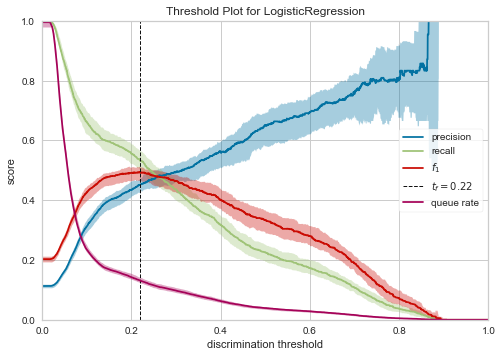

In [27]:
customer_subscription_prediction(logit, train_X, test_X, train_Y, test_Y,
                                cols, 'coefficients', threshold_plot=True)

# 5.2) Synthetic Minority Oversampling Technique (SMOTE)

In [28]:
from imblearn.over_sampling import SMOTE

cols = [i for i in df.columns if i not in target_col]

smote_X = df[cols]
smote_Y = df[target_col]

# split train & test data
smote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(smote_X, smote_Y,
                                                                           test_size = .25, random_state = 111)

# oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X, os_smote_Y = os.fit_sample(smote_train_X, smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X, columns = cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y, columns = target_col)

In [29]:
logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                                penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                                verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      9125
           1       0.34      0.64      0.44      1172

   micro avg       0.82      0.82      0.82     10297
   macro avg       0.64      0.74      0.67     10297
weighted avg       0.88      0.82      0.84     10297


Accuracy Score: 0.816548509274546
Area Under Curve: 0.741069615222778 



C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



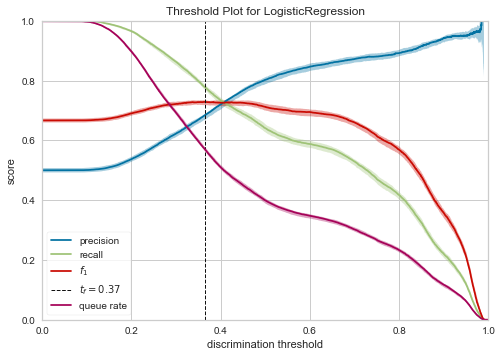

In [30]:
customer_subscription_prediction(logit_smote, os_smote_X, test_X, os_smote_Y, test_Y,
                                cols, 'coefficients', threshold_plot=True)

# 5.3) Recrusive Feature Elimination

In [31]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()

rfe = RFE(logit, 10)
rfe = rfe.fit(os_smote_X, os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

# identified columns recrusive feature elimation
idc_rfe = pd.DataFrame({'rfe_support':rfe.support_,
                       'columns':[i for i in df.columns if i not in target_col],
                       'ranking':rfe.ranking_,
                       })

cols = idc_rfe[idc_rfe['rfe_support'] == True]['columns'].tolist()

# seprating train & test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X = test[cols]
test_rf_Y = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                              intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                              penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                              verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.79      0.86      9125
           1       0.29      0.68      0.41      1172

   micro avg       0.77      0.77      0.77     10297
   macro avg       0.62      0.73      0.63     10297
weighted avg       0.87      0.77      0.81     10297


Accuracy Score: 0.7748858890939109
Area Under Curve: 0.732435831502174 



C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



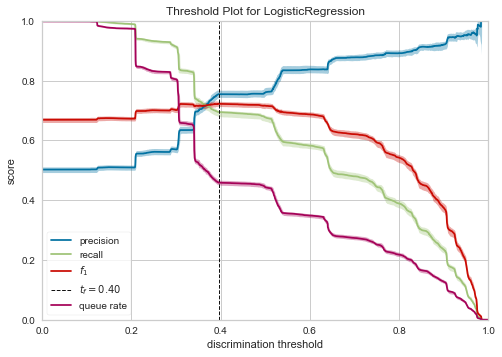

In [32]:
# applying model
customer_subscription_prediction(logit_rfe, train_rf_X, test_rf_X, train_rf_Y, test_rf_Y,
                                 cols, 'coefficients', threshold_plot=True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

# 5.4) Univariate Selection

In [33]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in df.columns if i not in target_col + ['emp.var.rate','cons.conf.idx']]

#dataframe with non negative values
df_x = df_og[cols]
df_y = df_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[5.47958309e+02 3.03843279e+01 1.76876859e+02 1.10065113e+01
 1.69798200e+00 6.71324420e-03 3.35662863e+02 8.64507734e-01
 3.88322963e+01 3.55864620e+02 1.30221961e+00 8.74260253e+00
 9.37694452e-04 4.11592011e+00 3.06235474e+01 8.67995049e+01
 1.11617940e+00 4.31547118e+00 2.15110197e+01 7.15924228e+01
 1.75910549e+00 2.16172373e+00 3.61736953e-02 7.36094532e+01
 1.81205348e+01 8.48762150e+01 3.21320431e+02 3.80868994e-01
 2.77292657e+00 2.07141139e-01 2.70442815e+00 1.89966009e-01
 2.07141139e-01 6.96920402e-01 2.23499582e+02 2.71895595e+00
 2.57887787e+02 3.53330416e+01 3.02405272e+00 8.42916583e+02
 3.21423320e+02 5.16043932e+00 7.63644573e+02 6.45541017e+02
 1.63296011e+00 1.47750439e+01 6.28141343e+00 2.14277851e+00
 1.31274314e+00 3.73481836e+01 2.10627558e+02 3.98254806e+03
 3.77442827e+03 3.85603530e+02 4.65108049e+01 1.59900476e+02
 1.21457706e+02 2.06268953e-03 7.63263646e+01 1.06657615e+03
 2.53705159e+02 3.09017243e+03 2.73615127e+00 3.24097408e+03
 5.23458160e+03]


# 5.5) Decision Tree Visualization

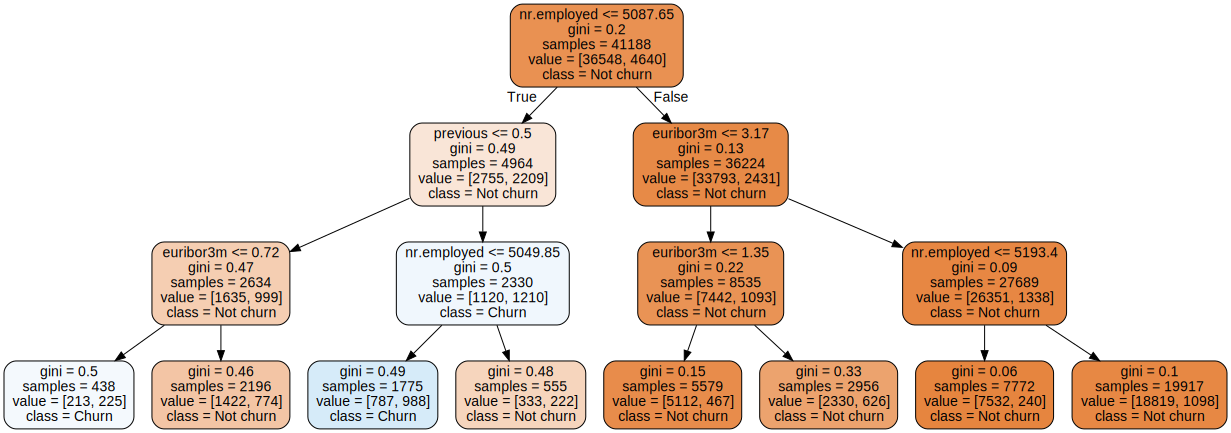

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG, display

# top 3 categorical features
features_cat = score[score['feature_type'] == 'Categorical']['features'][:3].tolist()

# top 3 numerical features
features_num = score[score['feature_type'] == 'Numerical']['features'][:3].tolist()

# function attributes
# columns = selected columns
# maximum_depth = depth of tree
# criterion_type = ['gini' or 'entropy']
# split_type = ['best' or 'random']
# model performance = True (gives model output)

def plot_decision_tree(columns, maximum_depth, criterion_type, split_type, model_performance = None):
    
    # sepreting dependent & independent variable
    dtc_x = df_x[columns]
    dtc_y = df_y[target_col]
    
    # model 
    dt_classifier = DecisionTreeClassifier(max_depth = maximum_depth,
                                          splitter = split_type,
                                          criterion = criterion_type,
                                          )
    dt_classifier.fit(dtc_x, dtc_y)
    
    # plot decision tree
    graph = Source(tree.export_graphviz(dt_classifier, out_file=None,
                                       rounded=True, proportion=False,
                                       feature_names = columns,
                                       precision=2,
                                       class_names = ['Not churn', 'Churn'],
                                       filled = True
                                       )
                  )
    
    # model performance
    if model_performance == True:
        customer_subscription_prediction(dt_classifier,
                                         dtc_x, test_X[columns],
                                         dtc_y, test_Y,
                                         columns, 'features', threshold_plot=True)
        
    display(graph)
    
plot_decision_tree(features_num,3,'gini','best')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      9125
           1       0.67      0.22      0.33      1172

   micro avg       0.90      0.90      0.90     10297
   macro avg       0.79      0.60      0.64     10297
weighted avg       0.88      0.90      0.88     10297


Accuracy Score: 0.8987083616587356
Area Under Curve: 0.6029997662349806 



C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



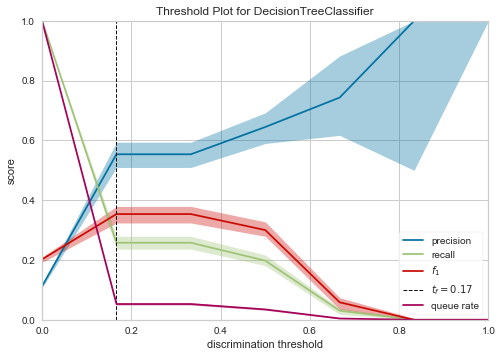

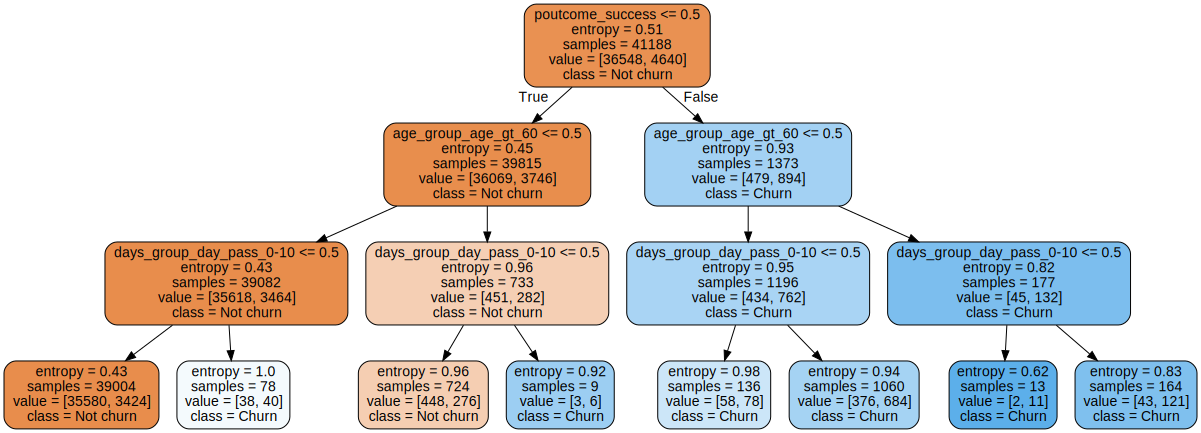

In [35]:
plot_decision_tree(features_cat, 3, 'entropy', 'best', model_performance = True)

# 5.6) KNN Classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83      9125
           1       0.24      0.63      0.35      1172

   micro avg       0.74      0.74      0.74     10297
   macro avg       0.59      0.69      0.59     10297
weighted avg       0.86      0.74      0.78     10297

Accuracy Scor: 0.7362338545207342
Area under curve: 0.6898053204918417


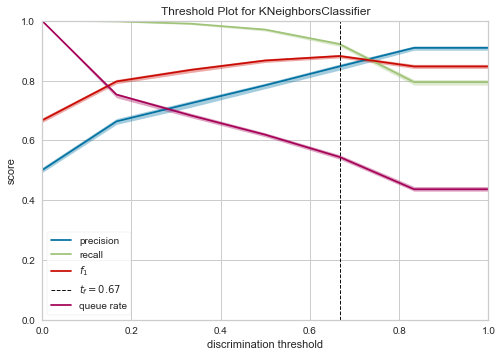

In [36]:
def customer_subscription_prediction_alg(algorithm, training_x, testing_x,
                                         training_y, testing_y, threshold_plot = True):
    
    # model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print(algorithm)
    print('\n Classification Report:\n', classification_report(testing_y, predictions))
    print('Accuracy Scor:', accuracy_score(testing_y, predictions))
    # confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    # roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions)
    print('Area under curve:', model_roc_auc)
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
    
    # plot roc curve
    trace1 = go.Scatter(x = fpr, y = tpr,
                       name = 'Roc :' + str(model_roc_auc),
                       line = dict(color = ('rgb(22,96,167)'), width = 2),
                       )
    trace2 = go.Scatter(x = [0,1], y = [0,1],
                       line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                                  dash = 'dot'))
    
    # plot confusion matrix
    trace3 = go.Heatmap(z = conf_matrix, x = ['Not churn', 'Churn'],
                       y = ['Not churn', 'Churn'],
                       showscale = False, colorscale ='Blues', name= 'matrix',
                       xaxis = 'x2', yaxis = 'y2'
                       )
    
    layout = go.Layout(dict(title = 'Model Performance',
                           autosize = False, height = 500, width = 800,
                           showlegend = False,
                           plot_bgcolor = 'rgb(243,243,243)',
                           paper_bgcolor = 'rgb(243,243,243)',
                           xaxis = dict(title = 'False Positive Rate',
                                       gridcolor = 'rgb(255,255,255)',
                                       domain = [0, 0.6],
                                       ticklen = 5, gridwidth = 2),
                           yaxis = dict(title = 'True Positive Rate',
                                       gridcolor = 'rgb(255,255,255)',
                                       zerolinewidth = 1,
                                       ticklen = 5, gridwidth = 2),
                           margin = dict(b = 200),
                           xaxis2 = dict(domain = [0.7, 1], tickangle = 90,
                                        gridcolor = 'rgb(255,255,255)'),
                           yaxis2 = dict(anchor = 'x2', gridcolor = 'rgb(255,255,255)')
                           )
                      )
    
    data = [trace1, trace2, trace3]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)
    
    if threshold_plot == True:
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x, training_y)
        visualizer.poof()
        
        
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'auto', leaf_size = 30, metric = 'minkowski',
                          metric_params=None, n_jobs = 1, n_neighbors = 5, p = 2,
                          weights = 'uniform')
customer_subscription_prediction_alg(knn, os_smote_X, test_X,
                                     os_smote_Y, test_Y, threshold_plot = True)

# 5.7) Visualize Decision Tree with Random Forest Classifier

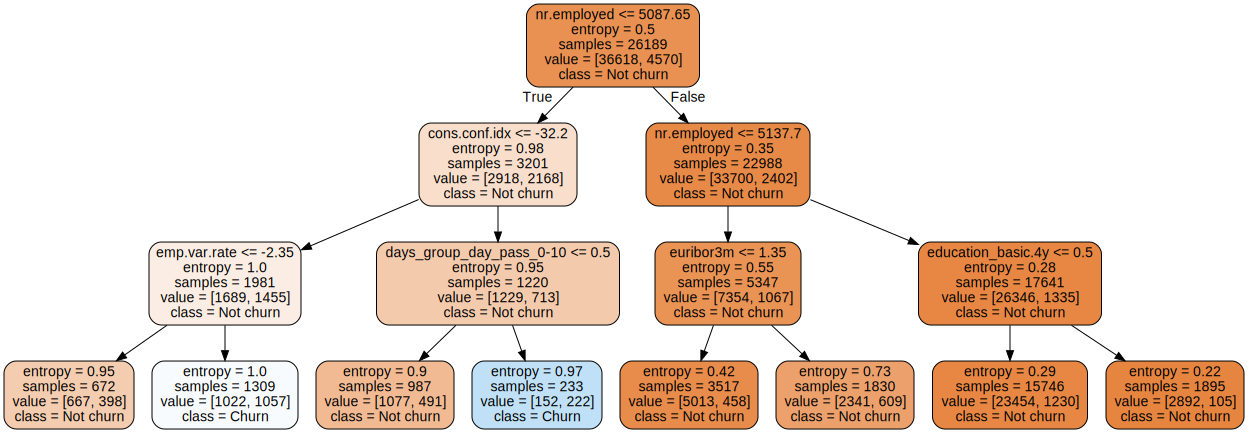

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      9125
           1       0.69      0.21      0.32      1172

   micro avg       0.90      0.90      0.90     10297
   macro avg       0.80      0.60      0.63     10297
weighted avg       0.88      0.90      0.87     10297


Accuracy Score: 0.8990968243177625
Area Under Curve: 0.5983851979989714 



C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



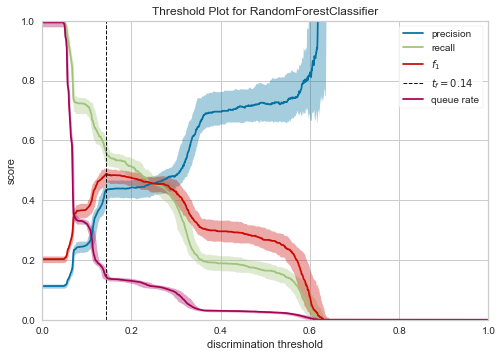

In [37]:
from sklearn.ensemble import RandomForestClassifier

# function attributes
# columns - column used
# nf_estimators = The number of trees in the forest
# estimated_tree = The number to be displayed
# maximum_depth = depth of tree
# criterion_type = split criterion type ['gini' or 'entropy']
# model performance = prints performance of model

def plot_tree_randomforest(columns, nf_estimators,
                          estimated_tree, maximum_depth,
                          criterion_type, model_performance = None):
    dataframe = df_og[columns + target_col].copy()
    
    # train and test dataset
    rf_x = dataframe[[i for i in columns if i not in target_col]]
    rf_y = dataframe[target_col]
    
    # random forest classifier
    rfc = RandomForestClassifier(n_estimators = nf_estimators,
                                max_depth = maximum_depth,
                                criterion = criterion_type,
                                )
    rfc.fit(rf_x, rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(estimated_tree, out_file = None,
                                       rounded = True, proportion = False,
                                       feature_names = columns,
                                       precision =2,
                                       class_names = ['Not churn', 'Churn'],
                                       filled = True))
    
    display(graph)
    
    # model performance
    if model_performance == True:
        customer_subscription_prediction(rfc, rf_x, test_X[columns],
                                         rf_y, test_Y,
                                         columns, 'features', threshold_plot = True)
        
cols1 = [i for i in train_X.columns if i not in target_col]
plot_tree_randomforest(cols1, 100, 99, 3, 'entropy', True)

# 5.8) Randm Forest Classifer

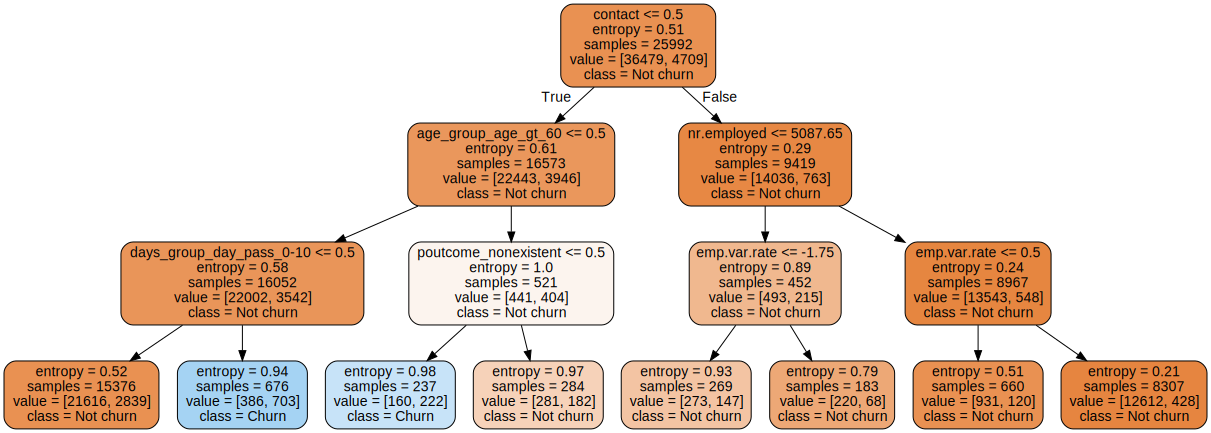

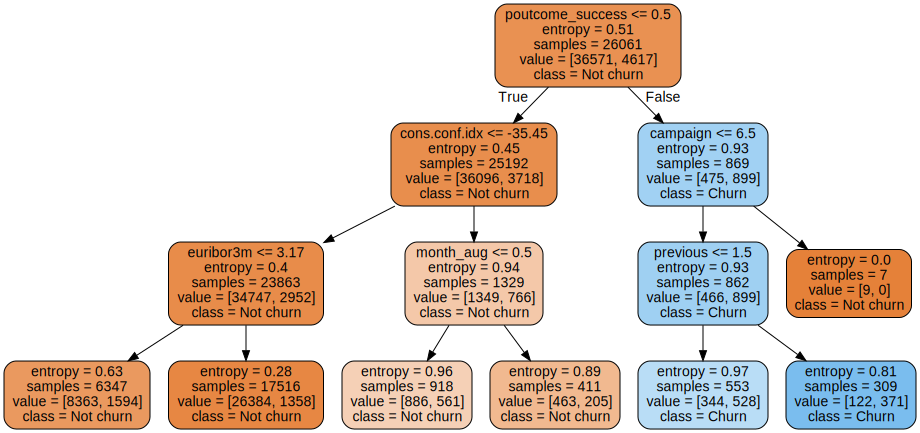

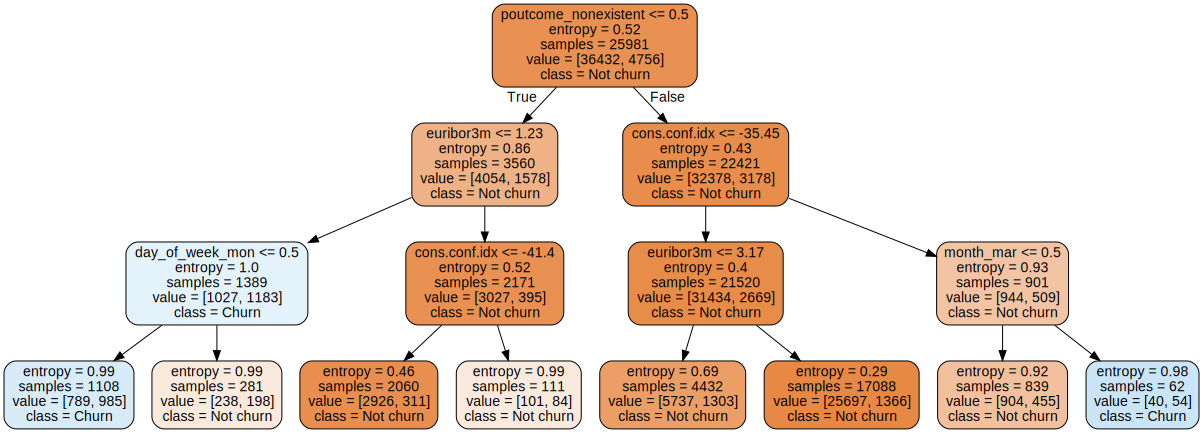

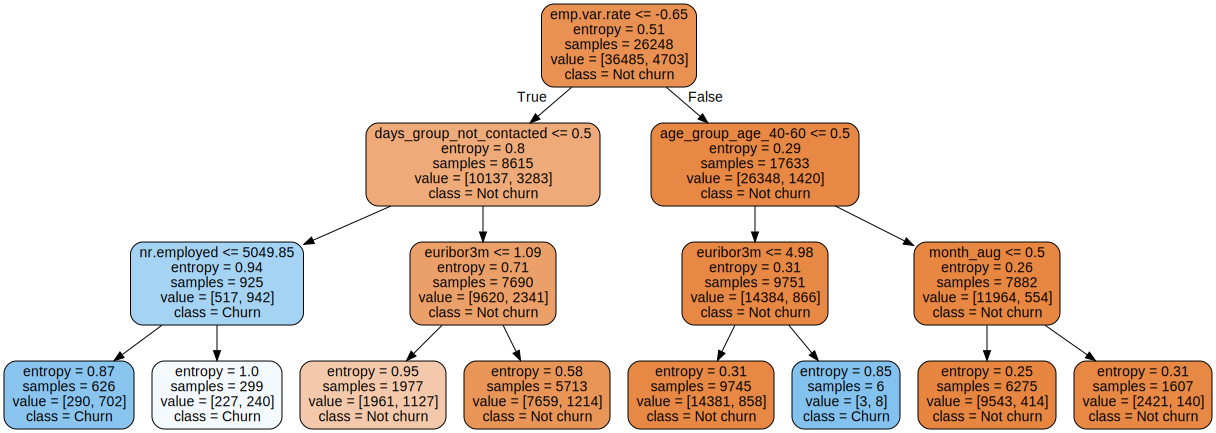

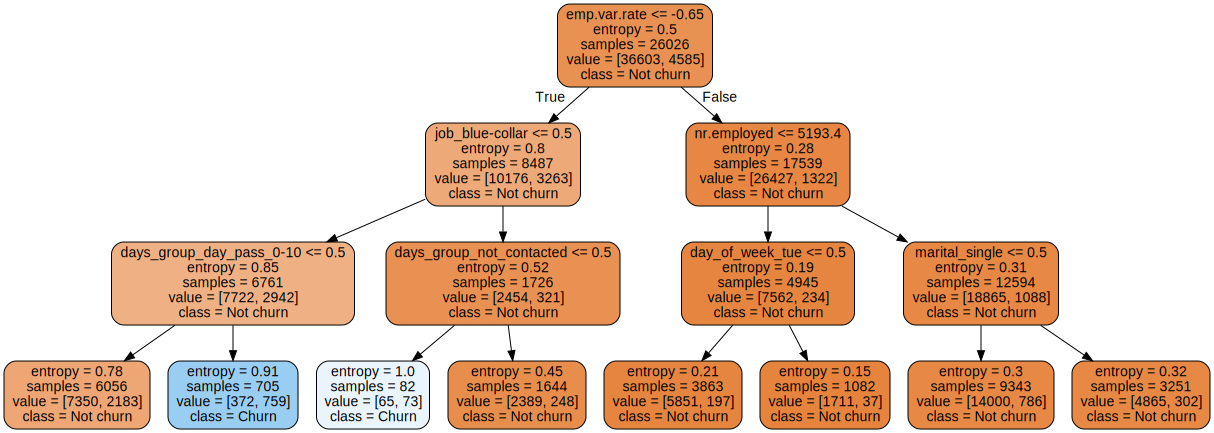

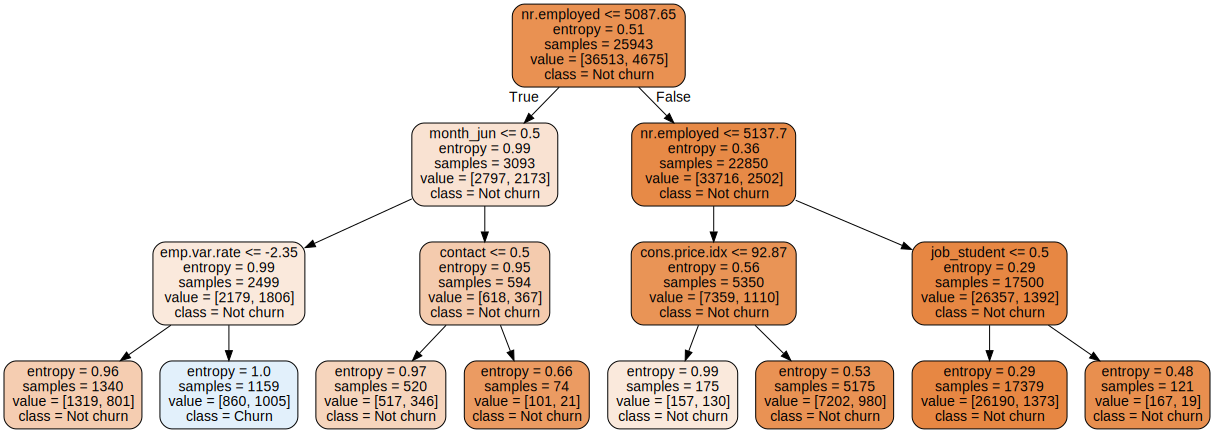

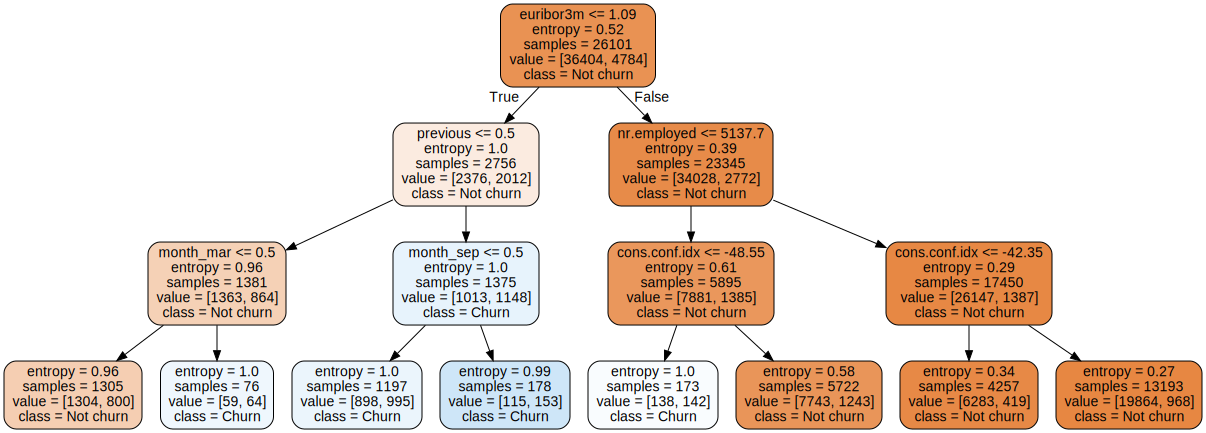

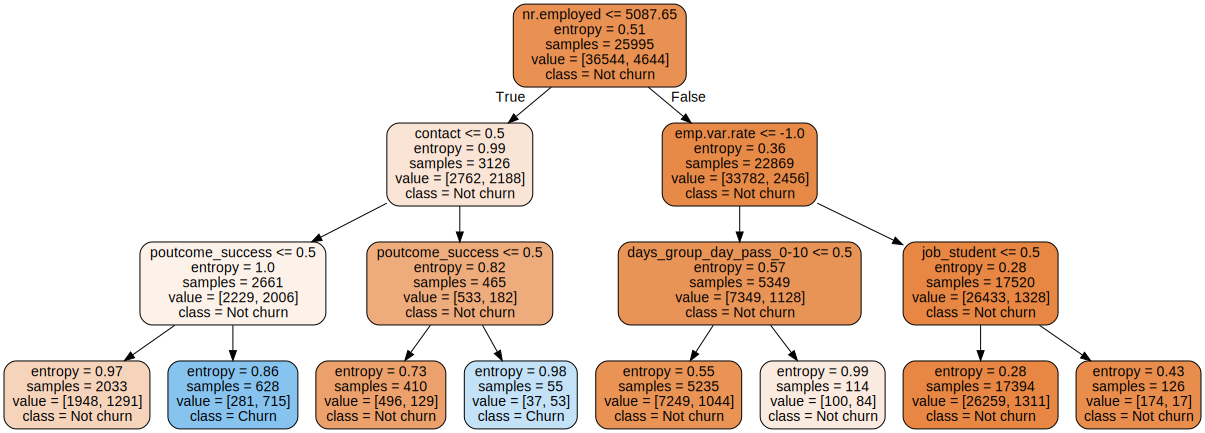

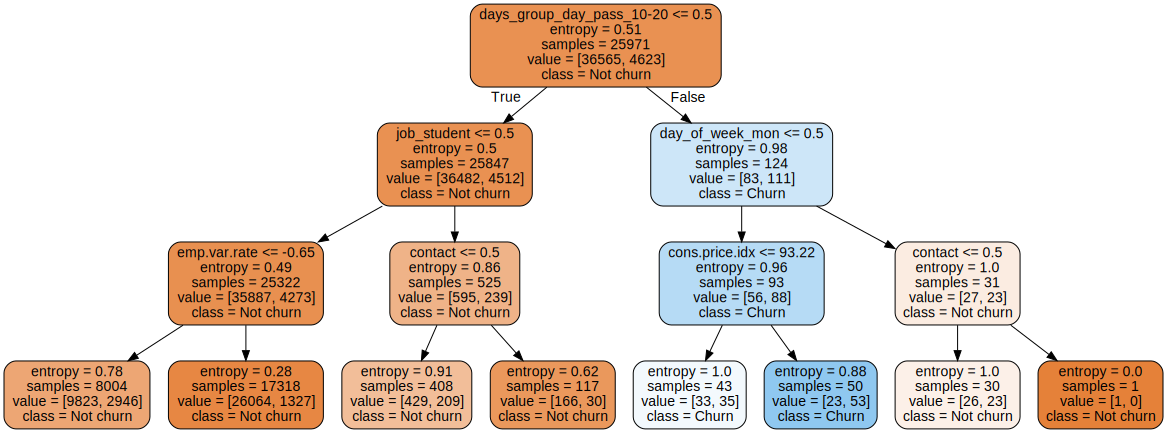

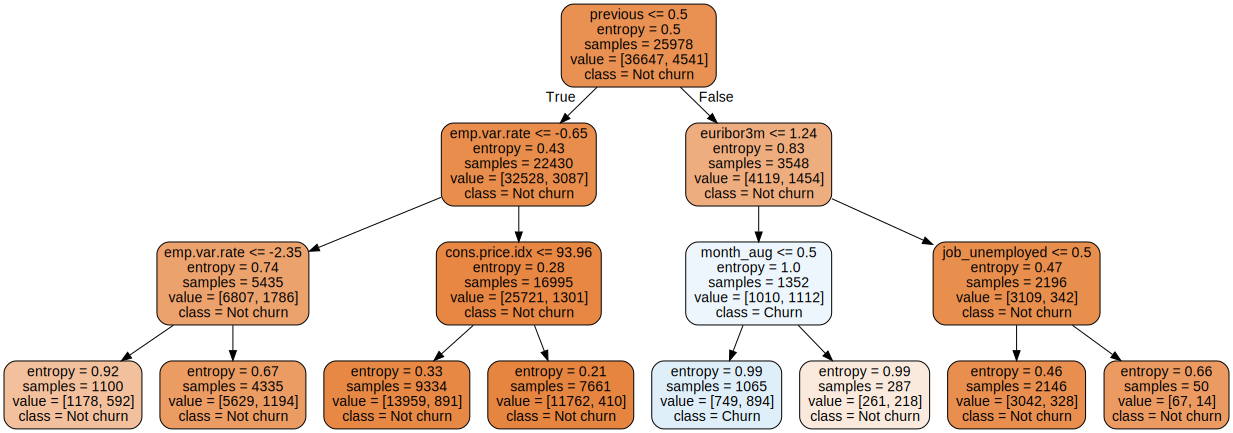

In [38]:
# making 10 trees with random forest 
n = np.arange(0,10).tolist()
cols1 = [i for i in train_X.columns if i not in target_col]
for i in n:
    plot_tree_randomforest(cols1, 10, i, 3, 'entropy',False)

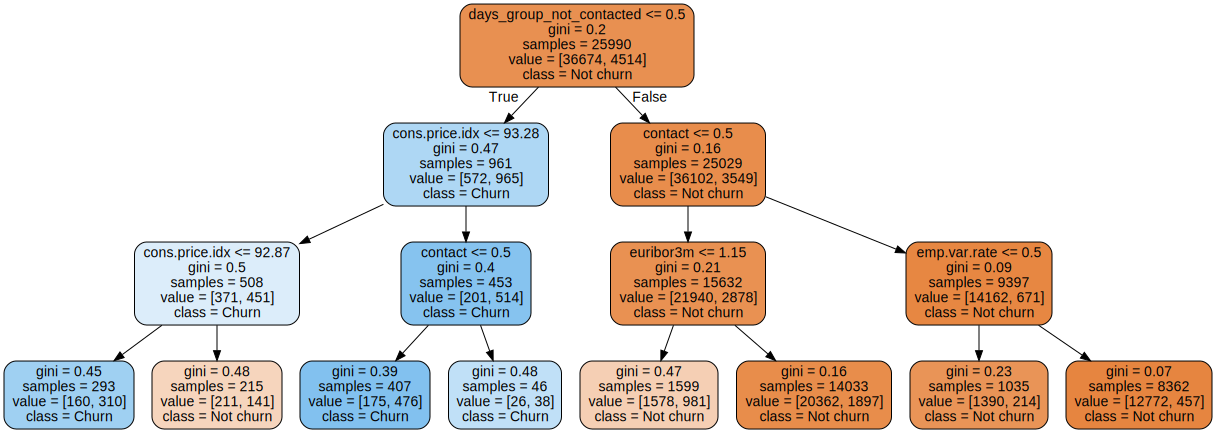

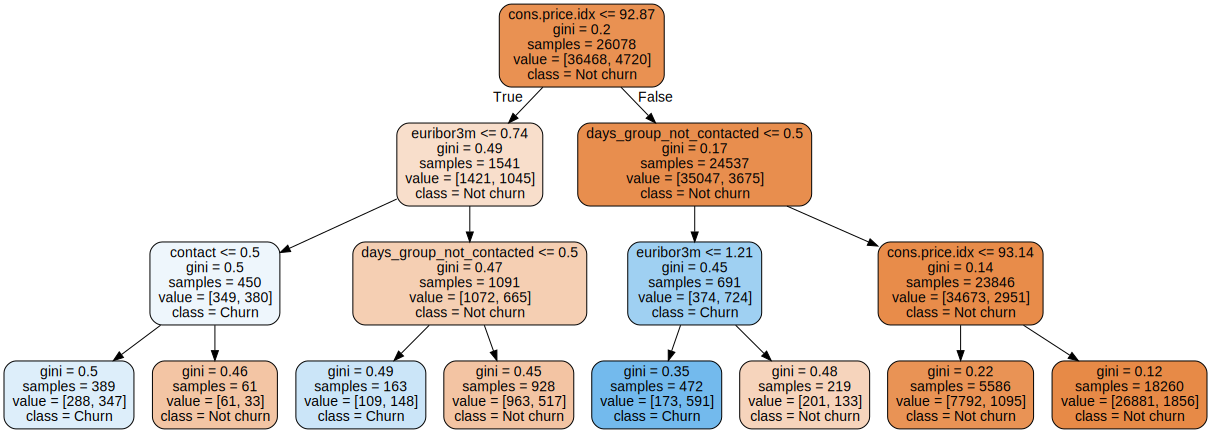

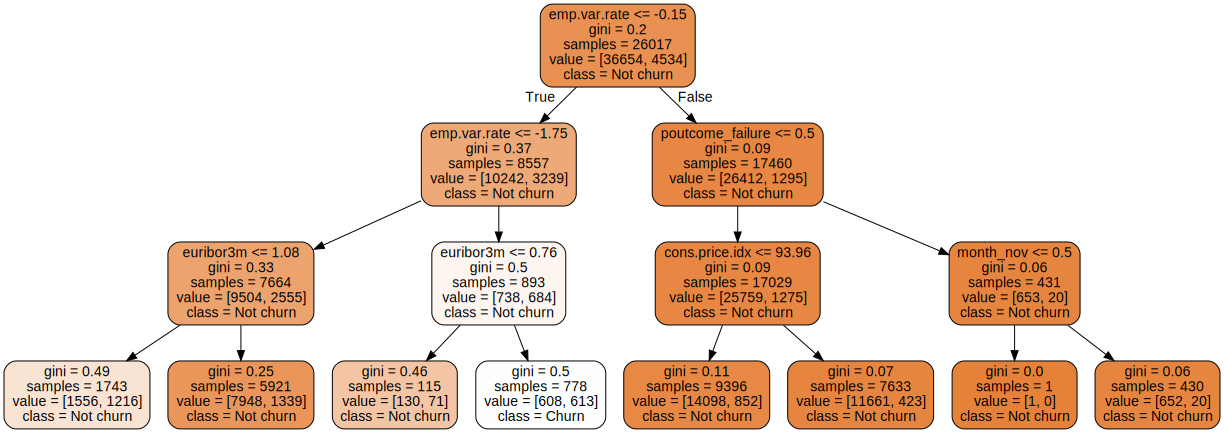

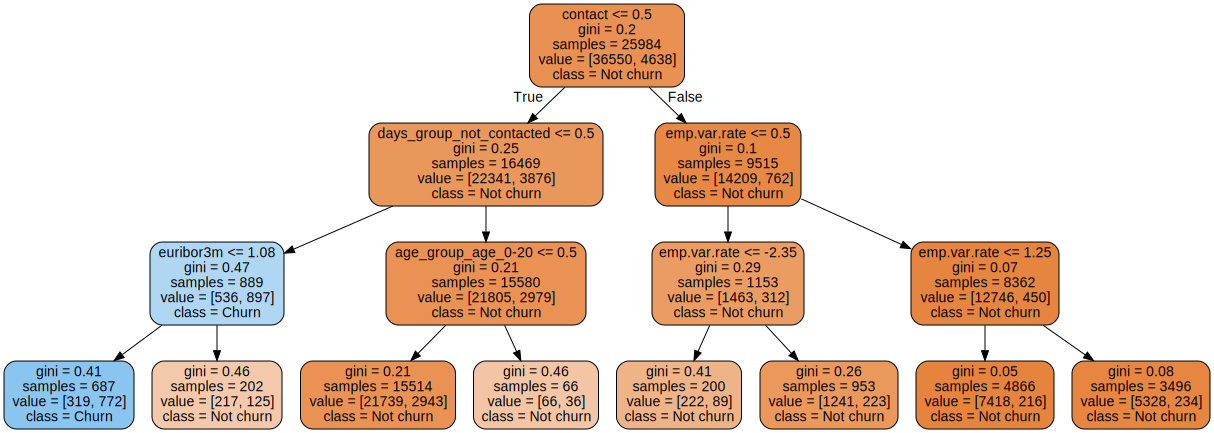

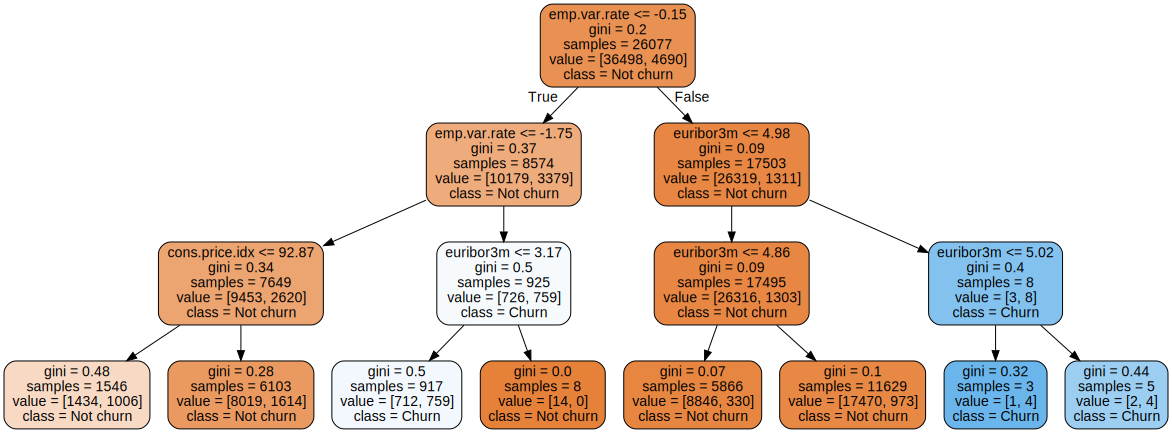

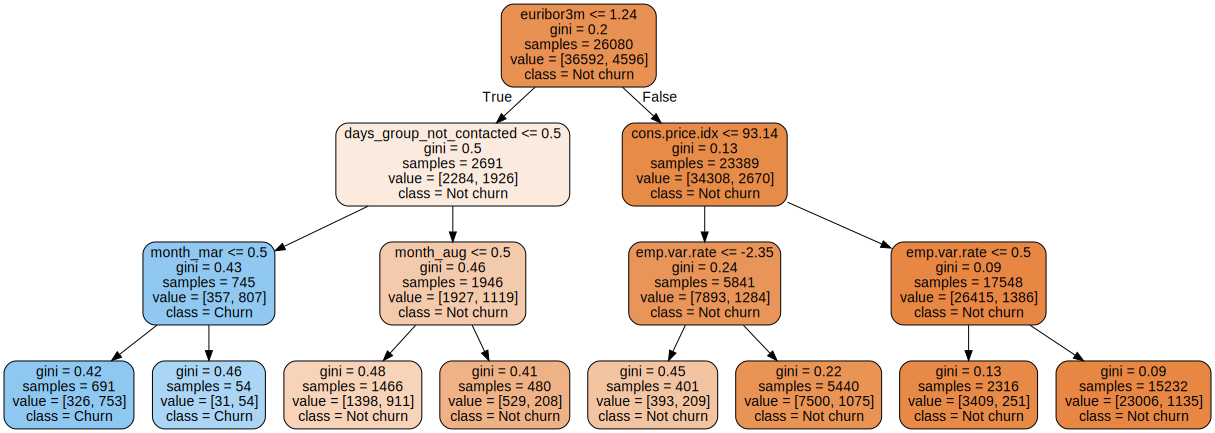

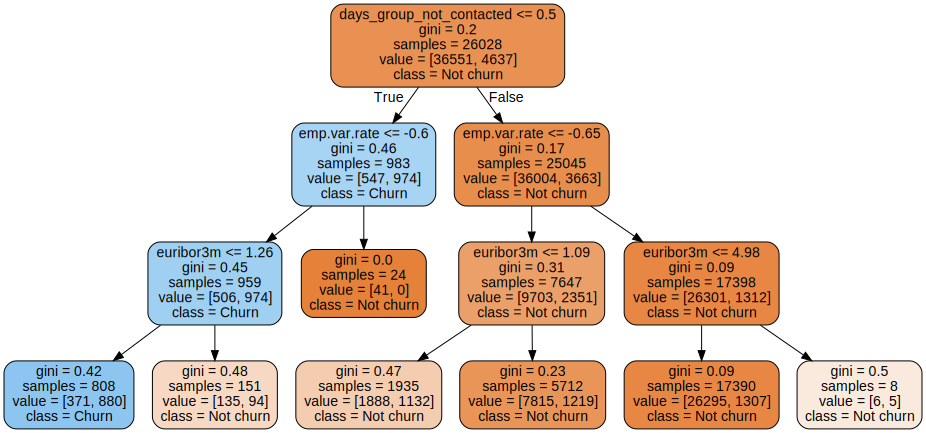

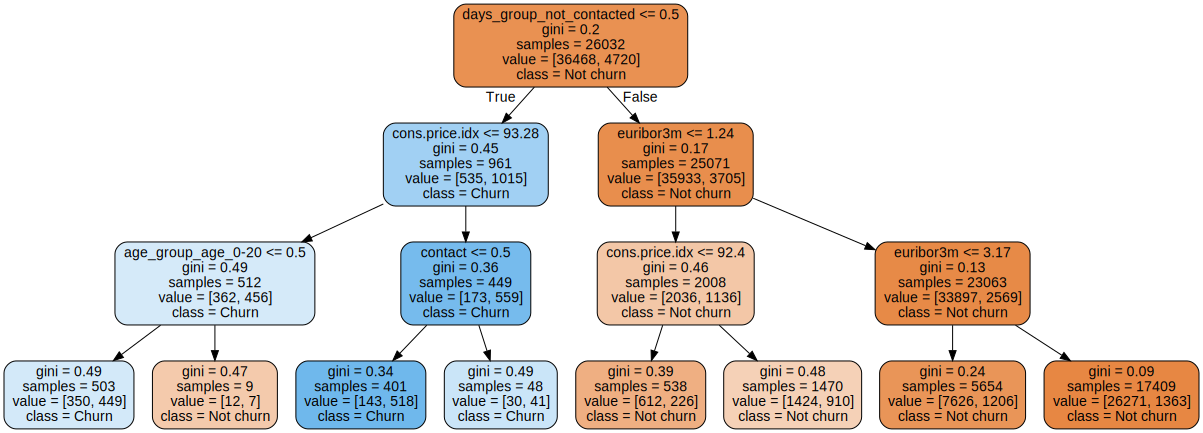

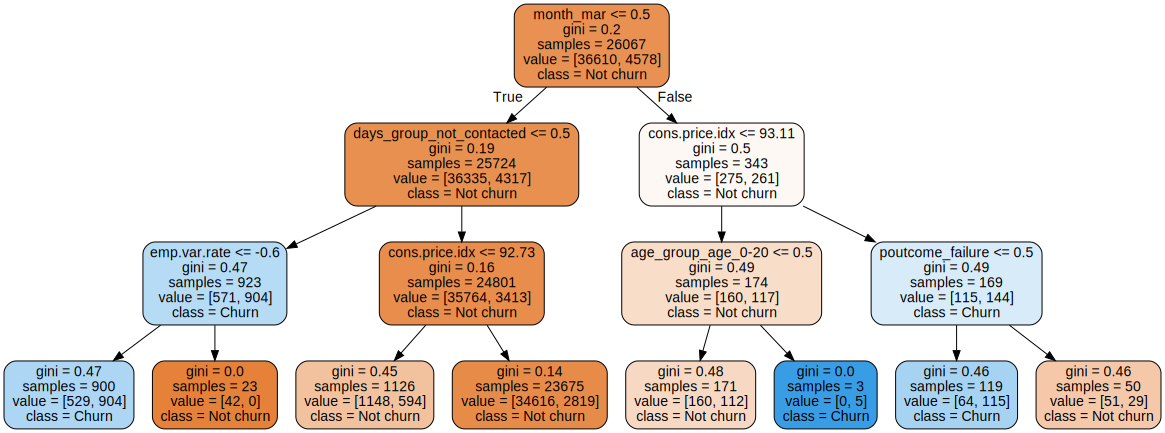

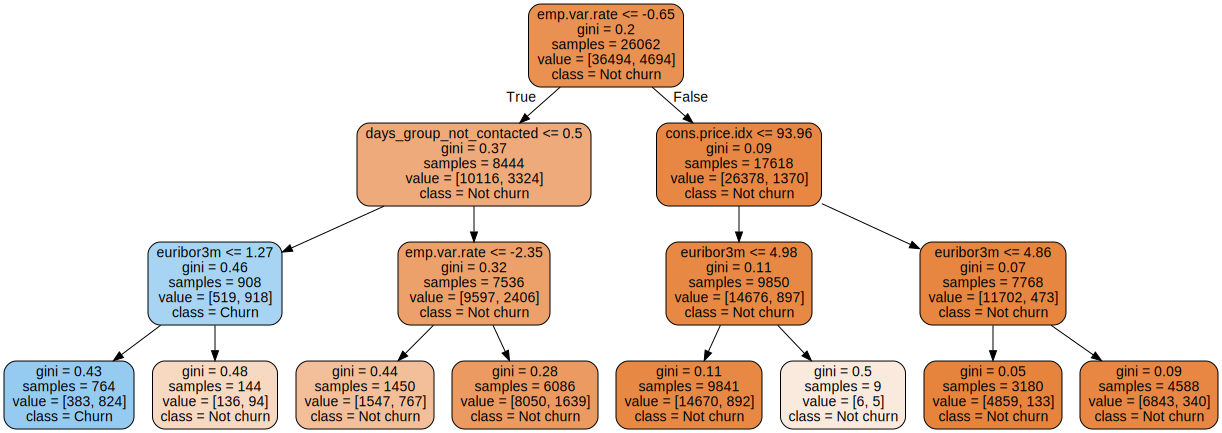

In [39]:
# making 10 trees with random forest for columns
# selected from recrusive feature elimination

n = np.arange(0,10).tolist()
cols = idc_rfe[idc_rfe['rfe_support'] == True]['columns'].tolist()
for i in n:
    plot_tree_randomforest(cols, 10, i, 3, 'gini', False)

# 5.9) Gaussian Naive Bayes

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      9125
           1       0.33      0.59      0.43      1172

   micro avg       0.82      0.82      0.82     10297
   macro avg       0.64      0.72      0.66     10297
weighted avg       0.87      0.82      0.84     10297

Accuracy Scor: 0.8197533262115179
Area under curve: 0.7190809294497171


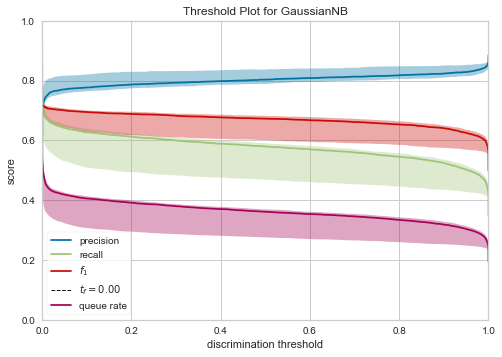

In [40]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors = None)

customer_subscription_prediction_alg(gnb, os_smote_X, test_X, os_smote_Y, test_Y)

# 5.10) LightGBM Classifier

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.5, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      9125
           1       0.53      0.34      0.42      1172

   micro avg       0.89      0.89      0.89     10297
   macro avg       0.73      0.65      0.68     10297
weighted avg       0.88      0.89      0.88     10297


Accuracy Score: 0.8907448771486841
Area Under Curve: 0.6527933049698443 



C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



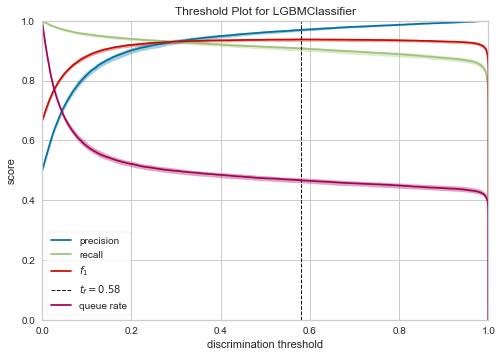

In [42]:
from lightgbm import LGBMClassifier

lgbm_c = LGBMClassifier(boosting_type = 'gbdt', class_weight=None, colsample_bytree =1.0,
                       learning_rate=0.5, max_depth=7, min_child_samples=20,
                       min_child_weight=0.001, min_split_gain = 0.0, n_estimators =100,
                       n_jobs = -1, num_leaves=500, objective='binary', random_state=None,
                       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                       subsample_for_bin=200000, subsample_freq= 0)

cols = [i for i in df.columns if i not in target_col]
customer_subscription_prediction(lgbm_c, os_smote_X, test_X, os_smote_Y, test_Y,
                                 cols, 'features', threshold_plot=True)

# 5.11) XGBoost Classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      9125
           1       0.49      0.35      0.40      1172

   micro avg       0.88      0.88      0.88     10297
   macro avg       0.70      0.65      0.67     10297
weighted avg       0.87      0.88      0.88     10297


Accuracy Score: 0.8837525492861998
Area Under Curve: 0.6492199261302539 



C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



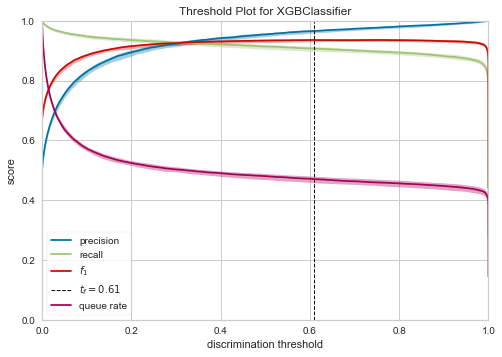

In [43]:
from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)


customer_subscription_prediction(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                                 cols,"features",threshold_plot = True)

# 6) Model Performance

# 6.1) Model Performance Metrics

In [44]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Reg(Baseline_model)")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Reg(SMOTE)")
model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Logistic Reg(RFE)")
decision_tree = DecisionTreeClassifier(max_depth = 9,
                                       random_state = 123,
                                       splitter  = "best",
                                       criterion = "gini",
                                      )
model4 = model_report(decision_tree,train_X,test_X,train_Y,test_Y,
                      "Decision Tree")
model5 = model_report(knn,os_smote_X,test_X,os_smote_Y,test_Y,
                      "KNN Classifier")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model6 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
model7 = model_report(gnb,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Naive Bayes")
model8 = model_report(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LGBM Classifier")
model9 = model_report(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "XGBoost Classifier")

#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,model6,
                                model7,model8,model9],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

# 6.2) Compare Model Performance Metrics

In [45]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )
trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)